# black-box regression results

Generates figures comparing performance on the black-box regression problems.

In [1]:
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('ps', fonttype=42)

import os
sns.set(font_scale=1.25, style='whitegrid')
sns.set(palette='magma')

# rdir = '../results/'
rdir = '../results_blackbox/'
pstreedir = '../results_blackbox_pstree/'
# figdir = 'figs/black-box' 
figdir = '../paper/'
# Set to path to PMLB datasets
datadir = '../datasets/pmlb/datasets/'
print('figdir:',figdir)
def save(name='tmp',h=None):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',figdir+'/'+name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')
    
symbolic_algs = [
    'AFP', 
    'AFP_FE',
    'BSR',
    'DSR',
    'FFX',

    # brush with mabs
    'Baseline',
    'Baseline-500',
    'B-wo-split',
    "C-D-UCB1",
    "C-D-UCB1-500",
    "C-D-TS",
    "D-UCB1",
    "D-UCB1-500",
    "D-TS",

    'FEAT S-Split',
    'FEAT SD-Split',
    'FEAT D-Split',
    'FEAT',

    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
    'AIFeynman'
]
nongp_algs = [
    'BSR',
    'DSR',
    'AIFeynman',
    "E2E"
]
gp_algs = [
    'AFP', 
    'AFP_FE',
    'FFX',

    'FEAT S-Split',
    'FEAT SD-Split',
    'FEAT D-Split',
    'FEAT',

    # brush with mabs
    'Baseline',
    'Baseline-500',
    'B-wo-split',
    "C-D-UCB1",
    "C-D-UCB1-500",
    "C-D-TS",
    "D-UCB1",
    "D-UCB1-500",
    "D-TS",

    'EPLEX',
    'GP-GOMEA',
    'gplearn',
    'ITEA', 
    'MRGP', 
    'Operon',
    'SBP-GP',
]

figdir: ../paper/


# read data from feather

In [2]:
##########
# load data from json
##########
frames = []
comparison_cols = [
    'dataset',
    'algorithm',
    'random_state',
    'time_time',
    'model_size',
    'symbolic_model',
    'r2_test',
    'mse_test',
    'mae_test',
    'params'
]
fails = []
import pdb
for f in tqdm(glob(rdir + '/*/*.json') + glob(pstreedir + '/*/*.json')):
    if 'cv_results' in f: 
        continue
    # leave out symbolic data
    if 'feynman_' in f or 'strogatz_' in f:
        continue
    # leave out LinearReg, Lasso (we have SGD with penalty)
    if any([m in f for m in ['LinearRegression','Lasso','EHCRegressor']]):
        continue
    try: 
        r = json.load(open(f,'r'))
        if isinstance(r['symbolic_model'],list):
#             print(f)
            sm = ['B'+str(i)+'*'+ri for i, ri in enumerate(r['symbolic_model'])]
            sm = '+'.join(sm)
            r['symbolic_model'] = sm
            
        sub_r = {k:v for k,v in r.items() if k in comparison_cols}
    #     df = pd.DataFrame(sub_r)
        frames.append(sub_r) 
    #     print(f)
    #     print(r.keys())
    except Exception as e:
        fails.append([f,e])
        pass


    
print(len(fails),'fails:',fails)
# df_results = pd.concat(frames)
df_results = pd.DataFrame.from_records(frames)
df_results['params_str'] = df_results['params'].apply(str)
df_results = df_results.drop(columns=['params'])
##########
# cleanup
##########
df_results = df_results.rename(columns={'time_time':'training time (s)'})
df_results.loc[:,'training time (hr)'] = df_results['training time (s)']/3600

# rename FeatStaticSplit to StaticSplit
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('featStaticSplit','FEAT S-Split'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('featSemiSplit','FEAT SD-Split'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('featDynamicSplit','FEAT D-Split'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('feat','FEAT(e-lex)'))

df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_C_D_UCB1_500','C-D-UCB1-500'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_C_D_UCB1','C-D-UCB1'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_C_D_TS','C-D-TS'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_D_UCB1_500','D-UCB1-500'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_D_UCB1','D-UCB1'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_D_TS','D-TS'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_wo_split','B-wo-split'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush_500','Baseline-500'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('brush','Baseline'))

df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('e2et','E2E'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('tpsr','TPSR+E2E'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('dso','uDSR'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('nesymres10M','NeSymRes 10M'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('nesymres100M','NeSymRes 100M'))

df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('PSTreeRegressor','PS-Tree'))
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('pstree','PS-Tree'))

# add modified R2 with 0 floor
df_results['r2_zero_test'] = df_results['r2_test'].apply(lambda x: max(x,0))

# label friedman ddatasets
df_results.loc[:,'friedman_dataset'] = df_results['dataset'].str.contains('_fri_')

print('loaded',len(df_results),'results')
# additional metadata

df_results['symbolic_alg'] = df_results['algorithm'].apply(lambda x: x in symbolic_algs)

for col in ['algorithm','dataset']:
    print(df_results[col].nunique(), col+'s')

##########
# save results
##########
df_results.to_feather('../results/black-box_results_local.feather')
print('results saved to ../results/black-box_results_local.feather')

########
print('mean trial count:')
print(df_results.groupby('algorithm')['dataset'].count().sort_values()
      / df_results.dataset.nunique())

100%|██████████| 13791/13791 [00:33<00:00, 407.91it/s]


14 fails: [['../results_blackbox/1196_BNG_pharynx/1196_BNG_pharynx_dso_29910.json', JSONDecodeError('Expecting value: line 1 column 1 (char 0)')], ['../results_blackbox/595_fri_c0_1000_10/595_fri_c0_1000_10_dso_29910.json', JSONDecodeError('Expecting value: line 1 column 1 (char 0)')], ['../results_blackbox/621_fri_c0_100_10/621_fri_c0_100_10_dso_16850.json', JSONDecodeError('Expecting value: line 1 column 1 (char 0)')], ['../results_blackbox/582_fri_c1_500_25/582_fri_c1_500_25_dso_860.json', JSONDecodeError('Expecting value: line 1 column 1 (char 0)')], ['../results_blackbox/623_fri_c4_1000_10/623_fri_c4_1000_10_dso_5390.json', JSONDecodeError('Expecting value: line 1 column 1 (char 0)')], ['../results_blackbox/605_fri_c2_250_25/605_fri_c2_250_25_dso_5390.json', JSONDecodeError('Expecting value: line 1 column 1 (char 0)')], ['../results_blackbox/1199_BNG_echoMonths/1199_BNG_echoMonths_dso_16850.json', JSONDecodeError('Expecting value: line 1 column 1 (char 0)')], ['../results_blackbox

In [3]:
##########
# load results
##########
df_results = pd.read_feather('../results/black-box_results.feather')

# # Brush results
# df_results_brush = pd.read_feather('../results/black-box_results_brush.feather')
# df_results = pd.concat([df_results_brush, df_results], axis=0)

# df_results_brush = pd.read_feather('../results/black-box_results_C_D_UCB1.feather')
# df_results = pd.concat([df_results_brush, df_results], axis=0)

# combine with local results ---------------------------------
df_results_local = pd.read_feather('../results/black-box_results_local.feather')
df_results = pd.concat([df_results_local, df_results], axis=0)

# removing feat (it was a sanity check)
# df_results = df_results.loc[df_results['algorithm']!='FEAT(e-lex)']

# Removing mislabeled datasets (these are clf, but PMLB v1.0 had it as regr)
df_results = df_results[ ~df_results["dataset"].isin(["banana", "titanic"]) ]

print('mean trial count:')
print(df_results.groupby('algorithm')['dataset'].count().sort_values()
      / df_results.dataset.nunique())

mean trial count:
algorithm
NeSymRes 10M    0.295082
TPSR+E2E        5.098361
E2E             6.803279
Baseline-500    7.631148
AIFeynman       7.688525
C-D-UCB1-500    7.688525
uDSR            7.795082
D-UCB1-500      8.122951
MRGP            9.745902
FEAT            9.827869
LGBM            9.836066
XGB             9.836066
AFP_FE          9.836066
SBP-GP          9.836066
RandomForest    9.836066
PS-Tree         9.836066
Operon          9.836066
AdaBoost        9.836066
MLP             9.836066
Linear          9.836066
KernelRidge     9.836066
AFP             9.836066
GP-GOMEA        9.836066
FFX             9.836066
gplearn         9.836066
EPLEX           9.836066
BSR             9.836066
DSR             9.836066
ITEA            9.836066
B-wo-split      9.860656
Baseline        9.942623
C-D-UCB1        9.959016
D-UCB1          9.959016
D-TS            9.967213
C-D-TS          9.967213
Name: dataset, dtype: float64


In [4]:
df_results['dataset'].nunique()

122

In [5]:
df_results['algorithm'].value_counts()

C-D-TS          1216
D-TS            1216
C-D-UCB1        1215
D-UCB1          1215
Baseline        1213
B-wo-split      1203
SBP-GP          1200
RandomForest    1200
Linear          1200
EPLEX           1200
Operon          1200
MLP             1200
LGBM            1200
KernelRidge     1200
ITEA            1200
gplearn         1200
GP-GOMEA        1200
FFX             1200
AFP_FE          1200
BSR             1200
DSR             1200
AFP             1200
AdaBoost        1200
PS-Tree         1200
XGB             1200
FEAT            1199
MRGP            1189
D-UCB1-500       991
uDSR             951
AIFeynman        938
C-D-UCB1-500     938
Baseline-500     931
E2E              830
TPSR+E2E         622
NeSymRes 10M      36
Name: algorithm, dtype: int64

In [6]:
# ignoring new datasets from PMLB that hasnt been benchmarked with other methods yet
# df_results[['algorithm', 'dataset']].value_counts().unstack().sum(axis=0).sort_values()

print(df_results.shape)
df_results = df_results[ ~df_results["dataset"].isin([
                                                        "nikuradse_2",
                                                        "nikuradse_1"
]) ]

print(df_results.shape)


(38703, 14)
(38469, 14)


In [7]:
# removing specific models (for results reporting --- there is several papers using these results)

print(df_results.shape)
df_results = df_results[ ~df_results["algorithm"].isin([
    "D-TS",
    "D-UCB1",
    "C-D-TS",
    "C-D-UCB1",
    # "C-D-UCB1-500", # with mab, with split, 500 gens
    "Baseline",       # no mab, with split, 250 gens
    # "Baseline-500", # no mab, with split, 500 gens
    # "B-wo-split",   # no mab, no split, 500 gens

    # "uDSR",
    # "E2E",
    # "TPSR+E2E",
    # "NeSymRes 10M",
    # "NeSymRes 100M",

    "FEAT(e-lex)",
    'FEAT SD-Split',
    'FEAT S-Split',
    'FEAT D-Split',
]) ]

print(df_results.shape)

(38469, 14)
(32494, 14)


## summarize results by dataset, including ranking

In [8]:
df_results2 = df_results.merge(df_results.groupby('dataset')['algorithm'].nunique().reset_index(),
                              on='dataset',suffixes=('','_count'))

                                       
# rankings per trial per dataset
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x: 
                                                                              round(x,3).rank(
                                                                              ascending=ascending))
    
df_sum = df_results2.groupby(['algorithm','dataset'],as_index=False).median()
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2

# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_sum[col+'_rank']=df_sum.groupby(['dataset'])[col].apply(lambda x: 
                                                                        round(x,3).rank(ascending=ascending)
                                                                  )
    df_sum[col+'_norm'] = df_sum.groupby('dataset')[col].apply(lambda x: (x-x.min())/(x.max()-x.min()))
    
###################
# save summary data
###################
df_sum.to_csv('../results/results_black-box_summary.csv.gz',compression='gzip',index=False)

df_sum

/tmp/ipykernel_1376216/776791570.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_results2[col+'_rank_per_trial']=df_results2.groupby(['dataset','random_state'])[col].apply(lambda x:
/tmp/ipykernel_1376216/776791570.py:8: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_results2[col+'_rank

,algorithm,dataset,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,...,r2_test_rank,r2_test_norm,model_size_rank,model_size_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
0,AFP,1027_ESL,13879.5,1210.966865,0.365049,0.442612,0.830930,20.5,0.336380,0.830930,...,19.0,0.939865,11.0,0.000770,19.0,0.939865,19.0,0.118757,19.0,0.105084
1,AFP,1028_SWD,13879.5,3017.658321,0.438023,0.538419,0.314517,47.0,0.838238,0.314517,...,19.0,0.834582,13.0,0.000378,19.0,0.807568,22.0,0.216281,22.0,0.208446
2,AFP,1029_LEV,13879.5,2622.206193,0.433124,0.508817,0.521904,23.5,0.728391,0.521904,...,19.0,0.939429,10.0,0.000229,19.0,0.934869,19.0,0.075079,19.0,0.070631
3,AFP,1030_ERA,13879.5,3007.024177,2.496171,1.299746,0.358716,36.5,0.835284,0.358716,...,20.0,0.919178,15.0,0.003315,20.0,0.917586,19.0,0.064576,19.0,0.068639
4,AFP,1089_USCrime,13879.5,590.939726,549.423049,18.823004,0.639671,25.0,0.164150,0.639671,...,21.0,0.822717,12.0,0.001007,21.0,0.780937,20.0,0.200320,20.0,0.286474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,uDSR,687_sleuth_ex1605,15109.0,131.786410,141.170915,9.966141,0.152769,17.0,0.036607,0.152769,...,17.0,0.993217,8.5,0.000265,17.0,0.318739,17.0,0.024875,17.0,0.080735
3386,uDSR,690_visualizing_galaxy,16322.5,184.995547,2014.580507,38.561387,0.778049,6.0,0.051388,0.778049,...,27.0,0.230256,2.0,0.000007,27.0,0.230256,27.0,0.884156,27.0,0.928467
3387,uDSR,695_chatfield_4,16322.5,166.287582,685.436921,16.286954,0.655720,15.0,0.046191,0.655720,...,24.0,0.979883,10.0,0.000064,24.0,0.757528,25.0,0.071948,25.0,0.212870
3388,uDSR,706_sleuth_case1202,16322.5,130.547787,5106.835836,48.027782,0.416964,10.0,0.036263,0.416964,...,21.0,0.990372,6.0,0.000465,21.0,0.627220,23.0,0.049883,23.0,0.143279


# plot comparisons

In [9]:

def compare(df_compare, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[],**kwargs):
    plt.figure()
    order = df_compare.groupby(y)[x].median().sort_values(ascending=False).index
    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    
    sns.catplot(data=df_compare, 
                kind='point',
#                 color='w',
                y=y,
                x=x,
                order=order,
                fliersize=0,
#                 notch=True,
                row=row,
                col=col,
                palette='flare_r',
                **kwargs
               )
    plt.ylabel('')
    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)
    
    save(name='_'.join(['cat-boxplot',x + '-by-'+ y]) )
    if col:
        save(name='_'.join(['cat-boxplot',x + '-by-'+ y] + [col]) )

## point plot comparisons on PMLB

Index(['PS-Tree', '*Operon', '*SBP-GP', '*B-wo-split', '*FEAT',
       '*Baseline-500', '*D-UCB1-500', '*EPLEX', 'XGB', '*C-D-UCB1-500',
       'LGBM', '*GP-GOMEA', 'AdaBoost', 'RandomForest', '*ITEA', '*AFP_FE',
       'NeSymRes 10M', '*AFP', '*FFX', 'KernelRidge', '*gplearn', '*DSR',
       '*MRGP', 'MLP', 'E2E', 'Linear', '*BSR', 'uDSR', 'TPSR+E2E',
       '*AIFeynman'],
      dtype='object', name='*algorithm*')


,r2_test,model_size,training time (s)
0,0.830930,20.5,1210.966865
1,0.314517,47.0,3017.658321
2,0.521904,23.5,2622.206193
3,0.358716,36.5,3007.024177
4,0.639671,25.0,590.939726
...,...,...,...
3385,0.152769,17.0,131.786410
3386,0.778049,6.0,184.995547
3387,0.655720,15.0,166.287582
3388,0.416964,10.0,130.547787


/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  func(x=x, y=y, **kwargs)
/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ch246537/.conda/envs/srbench/lib/pyth

saving ../paper//pairgrid-pointplot_r2_test_model_size_training-time-(s).pdf


<Figure size 640x480 with 0 Axes>

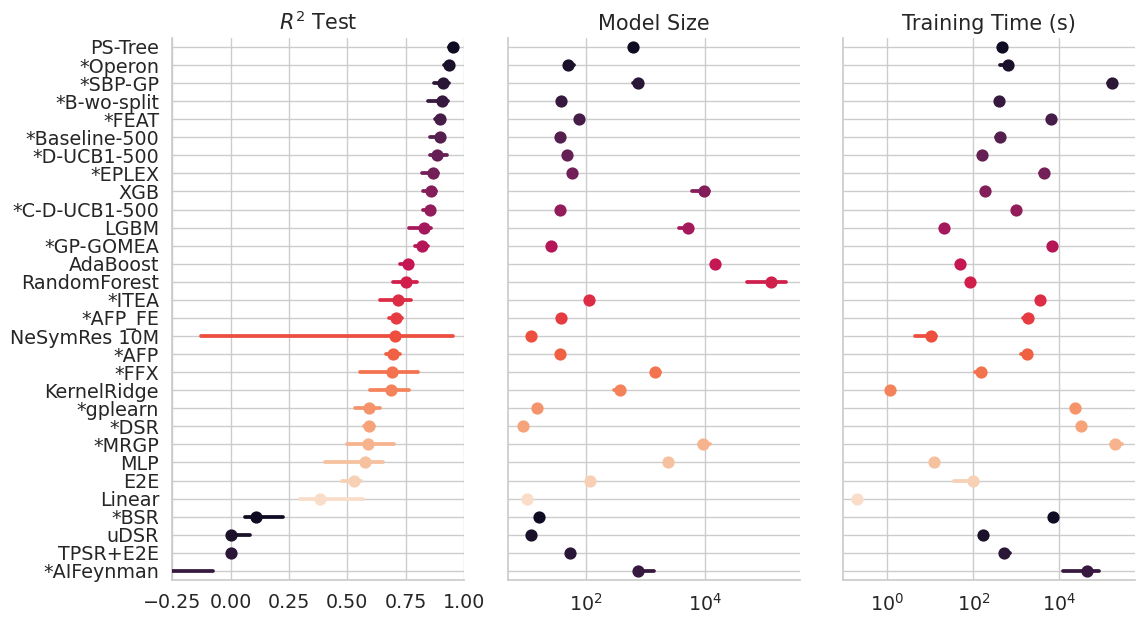

In [10]:
# Make the PairGrid
sns.set(font_scale=1.25, style='whitegrid')
# sns.set(palette='magma')
sns.despine(left=True, bottom=True)

df_plot=df_sum.copy()

df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)

# different options
x_vars=[
#         'r2_test_norm',
        'r2_test',
#         'r2_test_rank',
#        'rmse_test',
#         'log_mse_test',
        'model_size',
#         'model_size_rank',
       'training time (s)',
]
order = df_plot.groupby('*algorithm*')[x_vars[0]].median().sort_values(
                    ascending='r2' not in x_vars[0] or 'rank' in x_vars[0]).index

print(order)

display(df_plot[x_vars])
g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['*algorithm*'],
                 height=6.5, 
                 aspect=0.6,
                  hue="*algorithm*",
                  hue_order=order,
                  palette=sns.color_palette("rocket", n_colors=26),
#                  hue='symbolic_dataset'
                )

# Draw a dot plot 
g.map(sns.pointplot, 
      #size=10,
      orient="h",
      #jitter=False,
      order=order,
      hue_order=order,
      palette=sns.color_palette("rocket", n_colors=26),
      #linewidth=1,
      #markeredgecolor='w',
      join=False,
      estimator=np.median,
      n_boot=1000,
      ci=95
     )
# # Use semantically meaningful titles for the columns
titles = [x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$') for x in x_vars]
g.axes.flat[0].set_ylabel('')
for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)
    ax.set_xlabel('')
    
    if any([n in title.lower() for n in ['size','time']]):
        ax.set_xscale('log')
    
    if title == '$R^2$ Test':
        ax.set_xlim([-.25,1])

    # Make the grid horizontal instead of vertical
    ax.yaxis.grid(True)


save(name='_'.join(['pairgrid-pointplot']+x_vars))

## effect of friedman datasets

/home/ch246537/.conda/envs/srbench/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.87199254, 0.3633634, 0.35974223)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


saving ../paper//friedman_comparison_pairgrid-pointplot_normalized_R2_test.pdf


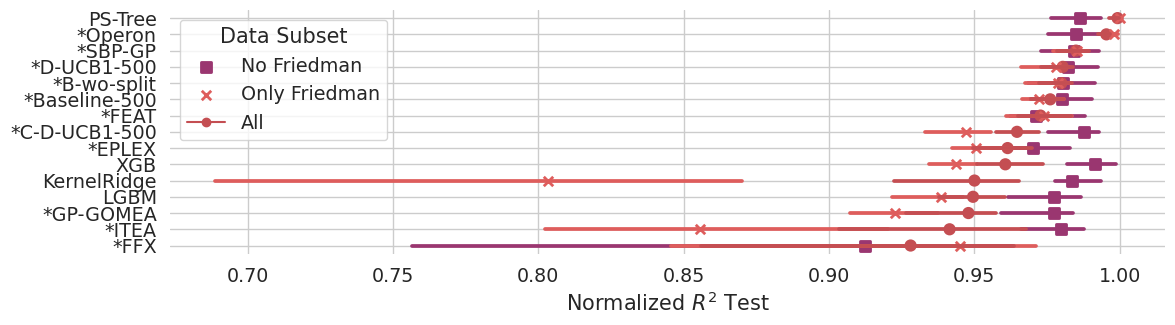

In [11]:
# Make the PairGrid
sns.set_style("whitegrid")
df_plot=df_sum.copy()
df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x if x in symbolic_algs else x)
df_plot = df_plot[['*algorithm*','r2_test','r2_test_norm','r2_test_rank','friedman_dataset']]

x='r2_test'
markers = ['o','s','x']
colors = sns.color_palette('flare',n_colors=3)
for x in ['r2_test_norm']:
    h = plt.figure(figsize=(12,3.5))
    ax = plt.gca()
    order = df_plot.groupby('*algorithm*')[x].median().sort_values(
                    ascending='r2' not in x or 'rank' in x).index[:15] # Change here to show only topN individuals
    i = 0
    axes = []
    g = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
                  hue='friedman_dataset',
                  #size=10,
                  orient="h",
                  order=order,
                  markers=['s','x'],
                  palette="flare_r",
                  join=False,
                  estimator=np.median,
                  #legend_out=True
                 )
    # all PMLB
    g2 = sns.pointplot(ax=ax,
                  data=df_plot,
                  x=x,
                  y='*algorithm*',
#                   hue='friedman_dataset',
                  #size=10,
                  orient="h",
                  order=order,
                  color='r',
#                   palette="flare_r",
                  join=False,
                  estimator=np.median,
                  markers = ['o'],
                  #legend_out=True
                 )
    # add all PMLB to legend
    handles, labels = ax.get_legend_handles_labels()
    #Create custom artists
    both = plt.Line2D((0,1),(0,0), color='r', marker='o', linestyle='-', label='All')
    handles.append(both)
    plt.legend(title='Data Subset',
               handles=handles, 
               labels=['No Friedman','Only Friedman','All'])
    
    if x=='r2_test':
        plt.xlim([-.5,1.0])
    if 'norm' in x:
        x='normalized_R2_test'
    sns.despine(left=True, bottom=True)
#         plt.title(prefix.replace('_',' ').title())
    axes.append(ax)
    i+=1
    plt.tight_layout()
    for ax in axes:
        ax.set_ylabel('')
        ax.set_xlabel(x.replace('_',' ').title().replace('(S)','(s)').replace('R2','$R^2$'))
        ax.yaxis.grid(True)
        ax.xaxis.grid(True)


    save(name='friedman_comparison_'+'_'.join(['pairgrid-pointplot']+[x]))

# training time versus dataset size

In [12]:
check_time = False
if check_time:
    import pandas as pd
    # for dataset, dfg in df_sum.groupby('dataset'):
    def get_size(dataset,i):
        df = pd.read_csv(datadir+dataset+'/'+dataset+'.tsv.gz',sep='\t') 
        return df.shape[i]

    df_sum.loc[:,'dataset_nsamples'] = df_sum['dataset'].apply(lambda x: get_size(x,0))
    df_sum.loc[:,'dataset_nsamples_train'] = df_sum['dataset'].apply(lambda x: min(get_size(x,0),10000))
    df_sum.loc[:,'dataset_nfeatures'] = df_sum['dataset'].apply(lambda x: get_size(x,1))
    df_sum.loc[:,'dataset_npoints'] = df_sum['dataset_nsamples']*df_sum['dataset_nfeatures']
    df_sum

In [13]:
if check_time:
    df_sum.algorithm.unique()

In [14]:
if check_time:

    df_sum['Method Family'] = df_sum['algorithm'].apply(lambda x: 'Operon' if x=='Operon' else 'XGB' if x=='XGB' else 'Other Non-GP SR' if x in nongp_algs else 'Other GP SR' if x in gp_algs else 'Other ML')

    order = [
        # 'FEAT SD-Split',
        # # 'FEAT S-Split',
        # 'FEAT D-Split',
        # 'FEAT(e-lex)',

        'B-wo-split',
        'Baseline',
        'Baseline-500',
        "C-D-UCB1",
        "C-D-UCB1-500",
        "C-D-TS",
        "D-UCB1",
        "D-TS",
    ]

    marker_choice = {
        # "FEAT S-Split"  : '<',
        # # "FEAT SD-Split"  : '*',
        # "FEAT D-Split"  : 'o',
        # "FEAT(e-lex)" : 's',

        'B-wo-split' : 's',
        'Baseline' : '*',
        'Baseline-500' : 'o',
        "C-D-UCB1" : '<',
        "C-D-UCB1-500" : '>',
        "C-D-TS" : '>',
        "D-UCB1" : 's',
        "D-TS" : 'o',
    }

    for col in ['dataset_nsamples_train','dataset_nsamples','dataset_nfeatures','dataset_npoints']:
        sns.set(palette='tab20')
        sns.set_style('whitegrid')
        sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.5})

        plt.figure(figsize=(6,6))
        ax = sns.lineplot(
            data=df_sum.loc[df_sum.algorithm.isin([
                #'Operon',
                # 'FEAT SD-Split',
                # 'FEAT S-Split',
                # 'FEAT D-Split',
                # 'FEAT(e-lex)',
                #'EPLEX',
                #'SBP-GP',
                #'XGB',
                #'DSR',

                'B-wo-split',
                'Baseline',
                'Baseline-500',
                "C-D-UCB1",
                "C-D-UCB1-500",
                "C-D-TS",
                "D-UCB1",
                "D-TS",
                ])],
            x = col,
            y = 'training time (hr)',
    #         hue='Method Family',
    #         style='Method Family',
            hue='algorithm',
            hue_order=order,
            style='algorithm',
            markers=marker_choice,
            markersize=8,
            markerfacecolor=None,
            err_style='bars',
            alpha=0.85
    #         facecolors=None
    #         scatter_kws = {'facecolors':'none'}
        )
        ax.set_yscale('log')
        ax.set_xscale('log')
    #     plt.legend(loc=[1.01,0])
        plt.xlabel(col.replace('_',' ').title())
        plt.ylabel('Training Time (hr)')
        save('training_time_'+col)

<!-- # scores on symbolic datasets (prelim) -->

# Pareto plot

Plot the method results as trade-offs between accuracy and simplicity

In [15]:
np.random.seed(42)
def bootstrap(val, n = 1000, fn=np.mean):
    val_samples = []
    for i in range(n):
        sample = np.random.randint(0,len(val)-1, size=len(val))
        val_samples.append( fn(val[sample]) )
    m = np.mean(val_samples)
    sd = np.std(val_samples)
    ci_upper  = np.quantile(val_samples,0.95)
    ci_lower  = np.quantile(val_samples,0.05)
    return m, sd, ci_upper,ci_lower

/tmp/ipykernel_1376216/1712681732.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pareto_data = data.groupby('*algorithm*').median()


PF: [9, 14, 6, 22, 23]
PF: [18, 28, 4, 8, 25]
PF: [29, 5, 7, 12]
PF: [0, 11, 27]
PF: [21, 1, 15, 16, 17]
AFP* 18.0 9.0


AFP_FE* 18.0 10.0
AIFeynman* 28.0 21.0
AdaBoost 15.5 26.0
B-wo-split* 8.0 8.5
BSR* 26.0 4.0
Baseline-500* 7.0 8.0
C-D-UCB1-500* 11.0 8.5
D-UCB1-500* 7.0 12.0
DSR* 21.0 2.0
E2E 22.0 17.0
EPLEX* 11.0 14.0
FEAT* 8.0 15.0
FFX* 16.25 22.0
GP-GOMEA* 12.75 7.0
ITEA* 16.0 17.0
KernelRidge 14.0 19.0
LGBM 11.0 24.0
Linear 22.0 3.0
MLP 15.5 24.0
MRGP* 19.0 26.5
NeSymRes 10M 22.0 9.0
Operon* 3.0 14.0
PS-Tree 2.0 20.0
RandomForest 15.25 28.0
SBP-GP* 5.0 20.0
TPSR+E2E 27.0 15.0
XGB 10.0 26.0
gplearn* 21.0 4.0
uDSR 27.0 3.0
saving ../paper//pareto_plot_r2_test_rank_model_size_rank.pdf


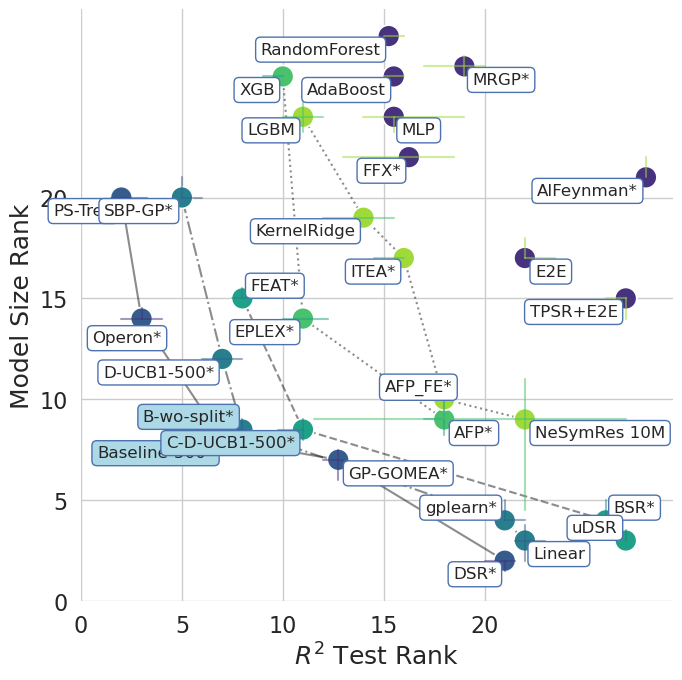

In [16]:
import pdb
from pareto_utils import front
sns.set(font_scale=1, style='whitegrid')
labelsize=18
plt.figure(figsize=(7,7))
data = df_sum.copy() #.loc[df_sum.algorithm.isin(symbolic_algs)]
data['*algorithm*'] = data['algorithm'].apply(lambda x: x+'*' if x in symbolic_algs else x)
xcol = 'r2_test_rank'
# xcol  = 'r2_test'
ycol = 'model_size_rank'
# ycol = 'model_size'
palette = 'viridis'
# outline pareto front
pareto_data = data.groupby('*algorithm*').median()

objs = pareto_data[[xcol,ycol]].values
# reverse R2 (objs are minimized)
# objs[:,0] = -objs[:,0]
levels = 5 # Change here to include or exclude models
styles=['-','-.','--',':', ':', ':', ':', ':', ':']
PFs = []
pareto_ranks = -np.ones(len(pareto_data))
for el in range(levels):
#     pdb.set_trace()
    PF = front(objs[:,0],objs[:,1])
    if len(PF)>0:
        print('PF:',PF)
        pareto_ranks[PF] = el
    objs[PF,:] = np.inf
    PFs.append(PF)
i = 0
pareto_data.loc[:,'pareto_rank'] = pareto_ranks
for pfset in PFs:
    xset,yset = [],[]

    for pf in pfset:
        xset.append(pareto_data[xcol].values[pf])
        yset.append( pareto_data[ycol].values[pf] )
    linestyle=styles[i]
    plt.plot(xset,yset, styles[i]+'k', alpha=0.5, zorder=1)
#     plt.gca().set_zorder(10)
    i+=1

cmap = sns.color_palette(palette=palette, 
                         n_colors=pareto_data.pareto_rank.nunique(), 
                         desat=None, 
                         as_cmap=False)

ax = sns.scatterplot(
    ax = plt.gca(),
#     ax = g.ax_joint,
#     data = data.groupby('*algorithm*').median(),
    data = pareto_data,
    x = xcol,
    y = ycol,
#     style='*algorithm*',
#     style='pareto_rank',
    hue = 'pareto_rank',
    s=250,
#     palette=palette,
    #     edgecolor='k'
    legend=False,
    palette=cmap
)
ax.set_zorder(2)
xoff = .4
yoff = 0.3
# xoff, yoff = 0, 0
for idx,row in pareto_data.iterrows():
    x=row[xcol]-xoff
    y=row[ycol]-yoff
    ha='right'
    
    if idx in ['Linear','MLP','MRGP*']: # ,'GP-GOMEA*'
        x=row[xcol]+xoff
        ha='left'
    elif idx == 'Operon*':
        x = row[xcol]+1
        y -= yoff
    elif idx  in ['uDSR','B-wo-split*']: # 'Baseline*', 
        #x = row[xcol]+1
        y = row[ycol]+1
    elif idx in ['gplearn*']:
#         x -= xoff
#         x=row[xcol]+xoff
        y = row[ycol]+1
#         ha='left'
    elif idx in ['AFP_FE*']:
        x=row[xcol]+xoff
        y = row[ycol]+1
    elif idx in ['FEAT*','FEAT S-Split*', 'BSR*',"C-D-UCB1*"]:
#         x -= xoff
        x=row[xcol]+xoff
        y = row[ycol]+1
        ha='left'
    elif idx in ['AFP*', 'E2E', 'NeSymRes 10M', "D-TS*", "GP-GOMEA*"]: #, 'DSR*', 'D-UCB1*', 
        ha='left'
        x = row[xcol]+0.5
        
    facecolor = 'w'
    if idx in ['Baseline*','Baseline-500*','B-wo-split*',"C-D-UCB1*","D-UCB1*",
               "C-D-UCB1-500*","C-D-TS*", "D-TS*"]:
        facecolor = 'lightblue'

    plt.text(s=idx,
             x = x, 
             y = y,
             ha=ha,
             va='top',
             bbox=dict(facecolor=facecolor, edgecolor='b', boxstyle='round', alpha=1)
            )
    
# confidence intervals
i = 0
for alg, dg in data.groupby('*algorithm*'):
    x = dg[xcol].median() 
    y = dg[ycol].median()
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
    print(alg, x, y)
    plt.plot(
             [cilx,ciux],
             [y, y],
             alpha=0.5,
             color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
#              color='b'
            )
    plt.plot(
             [x, x],
             [cily,ciuy],
             alpha=0.5,
             color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
#              color='b'
            )
    i += 1
    
ax.set_aspect(1.0)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ticksize=16
plt.xticks([0,5,10,15,20],fontsize=ticksize)
plt.yticks([0,5,10,15,20],fontsize=ticksize)
# ax.set_yscale('log')
plt.xlabel(xcol.replace('_',' ').replace('r2','$R^2$').title(), fontsize=labelsize)
plt.ylabel(ycol.replace('_',' ').title(), fontsize=labelsize)
sns.despine(left=True, bottom=True)
save(name="pareto_plot_"+xcol+'_'+ycol)

/tmp/ipykernel_1376216/997764316.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pareto_data = data.groupby('*algorithm*').median()


,random_state,training time (s),mse_test,mae_test,r2_test,model_size,training time (hr),r2_zero_test,friedman_dataset,symbolic_alg,...,r2_test_rank,r2_test_norm,model_size_rank,model_size_norm,r2_zero_test_rank,r2_zero_test_norm,rmse_test_rank,rmse_test_norm,log_mse_test_rank,log_mse_test_norm
*algorithm*,,,,,,,,,,,,,,,,,,,,,
AFP*,13879.5,1783.295709,0.438313,0.519851,0.695354,36.50,0.495360,0.695354,1.0,1.0,...,18.00,0.879412,9.0,1.837302e-04,18.00,0.773799,18.00,0.256624,18.00,0.216284
AFP_FE*,13879.5,1829.513145,0.430157,0.518399,0.709005,37.75,0.508198,0.709005,1.0,1.0,...,18.00,0.878893,10.0,1.795716e-04,18.00,0.771264,18.00,0.254214,18.00,0.228182
AIFeynman*,13879.5,42842.213292,2.897746,1.202983,-0.437132,742.00,11.900615,0.000000,1.0,1.0,...,28.00,0.000000,21.0,6.514259e-03,27.00,0.000000,28.00,1.000000,28.00,1.000000
AdaBoost,13879.5,47.922411,0.350307,0.459370,0.759914,14668.50,0.013312,0.759914,1.0,0.0,...,15.50,0.915685,26.0,6.132360e-02,15.50,0.810050,15.25,0.210785,15.25,0.182083
B-wo-split*,16322.5,385.477537,0.176234,0.323885,0.905740,37.50,0.107077,0.905740,1.0,1.0,...,8.00,0.979918,8.5,1.568021e-04,8.00,0.960657,8.00,0.061533,8.00,0.050658
BSR*,13879.5,7200.007611,0.996942,0.806952,0.109722,16.00,2.000002,0.109722,1.0,1.0,...,26.00,0.567988,4.0,9.151059e-05,26.00,0.166236,26.00,0.587487,26.00,0.565974
Baseline-500*,16322.5,406.100235,0.149604,0.293112,0.896081,36.50,0.112806,0.896081,1.0,1.0,...,7.00,0.976084,8.0,1.868460e-04,7.00,0.951727,7.00,0.069863,7.00,0.052406
C-D-UCB1-500*,16322.5,975.333529,0.226486,0.371446,0.855144,36.75,0.270926,0.855144,1.0,1.0,...,11.00,0.964649,8.5,1.438030e-04,11.00,0.920212,10.00,0.107420,10.00,0.075656
D-UCB1-500*,16322.5,159.426786,0.163795,0.325765,0.883491,48.50,0.044285,0.883491,1.0,1.0,...,7.00,0.980389,12.0,2.079205e-04,7.00,0.955359,7.00,0.054470,7.00,0.046214


PF: [6, 1, 0, 7]
PF: [2, 3, 5]
saving ../paper//pareto_plot_r2_test_model_size.pdf


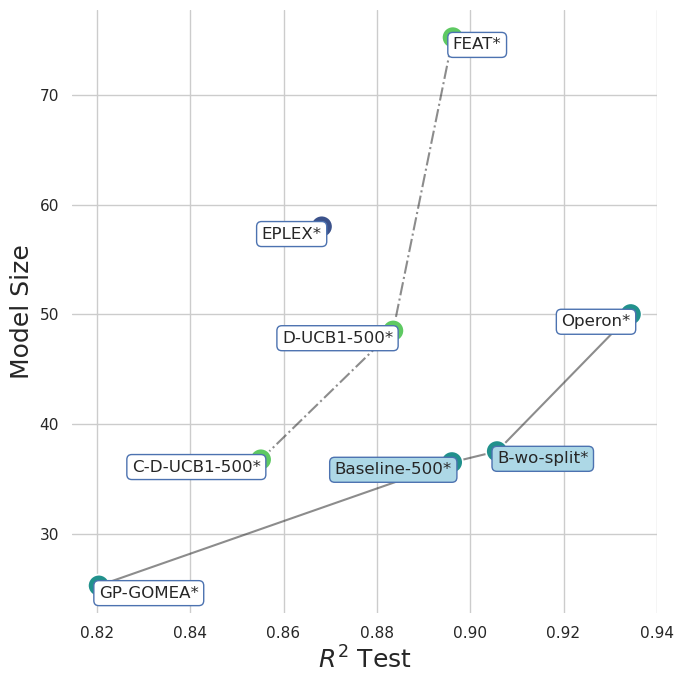

In [17]:
import pdb
from pareto_utils import front
sns.set(font_scale=1, style='whitegrid')
labelsize=18
plt.figure(figsize=(7,7))
data = df_sum.copy() #.loc[df_sum.algorithm.isin(symbolic_algs)]
data['*algorithm*'] = data['algorithm'].apply(lambda x: x+'*' if x in symbolic_algs else x)
# xcol = 'r2_test_rank'
xcol  = 'r2_test'
# ycol = 'model_size_rank'
ycol = 'model_size'
palette = 'viridis'
# outline pareto front
pareto_data = data.groupby('*algorithm*').median()

display(pareto_data)
fn_func = (pareto_data[xcol] >= 0.8) & (pareto_data[ycol] <= 100)

pareto_data = pareto_data[fn_func]

objs = pareto_data[[xcol,ycol]].values
# reverse R2 (objs are minimized)
objs[:,0] = -objs[:,0]
levels = 2 # Change here to include or exclude models
styles=['-','-.','--',':', ':', ':', ':', ':', ':']
PFs = []
pareto_ranks = -np.ones(len(pareto_data))
for el in range(levels):
#     pdb.set_trace()
    PF = front(objs[:,0],objs[:,1])
    if len(PF)>0:
        print('PF:',PF)
        pareto_ranks[PF] = el
    objs[PF,:] = np.inf
    PFs.append(PF)
i = 0
pareto_data.loc[:,'pareto_rank'] = pareto_ranks
for pfset in PFs:
    xset,yset = [],[]

    for pf in pfset:
        xset.append(pareto_data[xcol].values[pf])
        yset.append( pareto_data[ycol].values[pf] )
    linestyle=styles[i]
    plt.plot(xset,yset, styles[i]+'k', alpha=0.5, zorder=1)
#     plt.gca().set_zorder(10)
    i+=1

cmap = sns.color_palette(palette=palette, 
                         n_colors=pareto_data.pareto_rank.nunique(), 
                         desat=None, 
                         as_cmap=False)

ax = sns.scatterplot(
    ax = plt.gca(),
#     ax = g.ax_joint,
#     data = data.groupby('*algorithm*').median(),
    data = pareto_data ,
    x = xcol,
    y = ycol,
#     style='*algorithm*',
#     style='pareto_rank',
    hue = 'pareto_rank',
    s=250,
#     palette=palette,
    #     edgecolor='k'
    legend=False,
    palette=cmap
)
ax.set_zorder(2)
# xoff = .4
# yoff = 0.03
xoff, yoff = 0, 0
for idx,row in pareto_data.iterrows():
    x=row[xcol]-xoff
    y=row[ycol]-yoff
    ha='right'
    
    if idx in ['Linear','MLP','MRGP*']: # ,'GP-GOMEA*'
        x=row[xcol]#+xoff
        ha='left'
    elif idx == 'Operon*':
        x = row[xcol]#+1
        y -= yoff
    elif idx  in ['uDSR']: # 'Baseline*', 
        #x = row[xcol]+1
        y = row[ycol]+1
    elif idx in ['gplearn*']:
#         x -= xoff
#         x=row[xcol]+xoff
        y = row[ycol]+1
#         ha='left'
    elif idx in ['AFP_FE*']:
        x=row[xcol]+xoff
        y = row[ycol]#+1
    elif idx in ['FEAT*','FEAT S-Split*', 'BSR*',"C-D-UCB1*"]:
#         x -= xoff
        x=row[xcol]+xoff
        y = row[ycol]#+1
        ha='left'
    elif idx in ['AFP*', 'E2E', 'NeSymRes 10M', "D-TS*", "GP-GOMEA*"]: #, 'DSR*', 'D-UCB1*', 
        ha='left'
        x = row[xcol]#+0.5
    elif idx in ['B-wo-split*']:
        ha='left'

    facecolor = 'w'
    if idx in ['Baseline*','Baseline-500*',"C-D-UCB1*","D-UCB1*", "C-D-TS*", "D-TS*",'B-wo-split*']: #,
        facecolor = 'lightblue'

    #ha='left'
    plt.text(s=idx,
            x = x, 
            y = y,
            ha=ha,
            va='top',
            bbox=dict(facecolor=facecolor, edgecolor='b', boxstyle='round', alpha=1)
            )
    
# confidence intervals
# i = 0
# for alg, dg in data.groupby('*algorithm*'):
#     x = dg[xcol].median() 
#     y = dg[ycol].median()
#     _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
#     _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
#     print(alg, x, y)
#     plt.plot(
#              [cilx,ciux],
#              [y, y],
#              alpha=0.5,
#              color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
# #              color='b'
#             )
#     plt.plot(
#              [x, x],
#              [cily,ciuy],
#              alpha=0.5,
#              color=cmap[int(pareto_data.loc[alg,'pareto_rank'])]
# #              color='b'
#             )
#     i += 1
    
# ax.set_aspect(1.0)
# ax.set_xlim(left=0)
# ax.set_ylim(bottom=0)
ticksize=16
# plt.xticks([0,5,10,15,20],fontsize=ticksize)
# plt.yticks([0,5,10,15,20],fontsize=ticksize)
# ax.set_yscale('log')
plt.xlabel(xcol.replace('_',' ').replace('r2','$R^2$').title(), fontsize=labelsize)
plt.ylabel(ycol.replace('_',' ').title(), fontsize=labelsize)
sns.despine(left=True, bottom=True)
save(name="pareto_plot_"+xcol+'_'+ycol)

In [18]:
objs

array([[        inf,         inf],
       [        inf,         inf],
       [        inf,         inf],
       [        inf,         inf],
       [-0.86818937, 58.        ],
       [        inf,         inf],
       [        inf,         inf],
       [        inf,         inf]])

In [19]:
pareto_data['pareto_rank']

*algorithm*
B-wo-split*      0.0
Baseline-500*    0.0
C-D-UCB1-500*    1.0
D-UCB1-500*      1.0
EPLEX*          -1.0
FEAT*            1.0
GP-GOMEA*        0.0
Operon*          0.0
Name: pareto_rank, dtype: float64

/tmp/ipykernel_1376216/827858617.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_clustermap = data[["dataset", "*algorithm*", "r2_test_rank"]]\


saving ../paper//clustermap.pdf


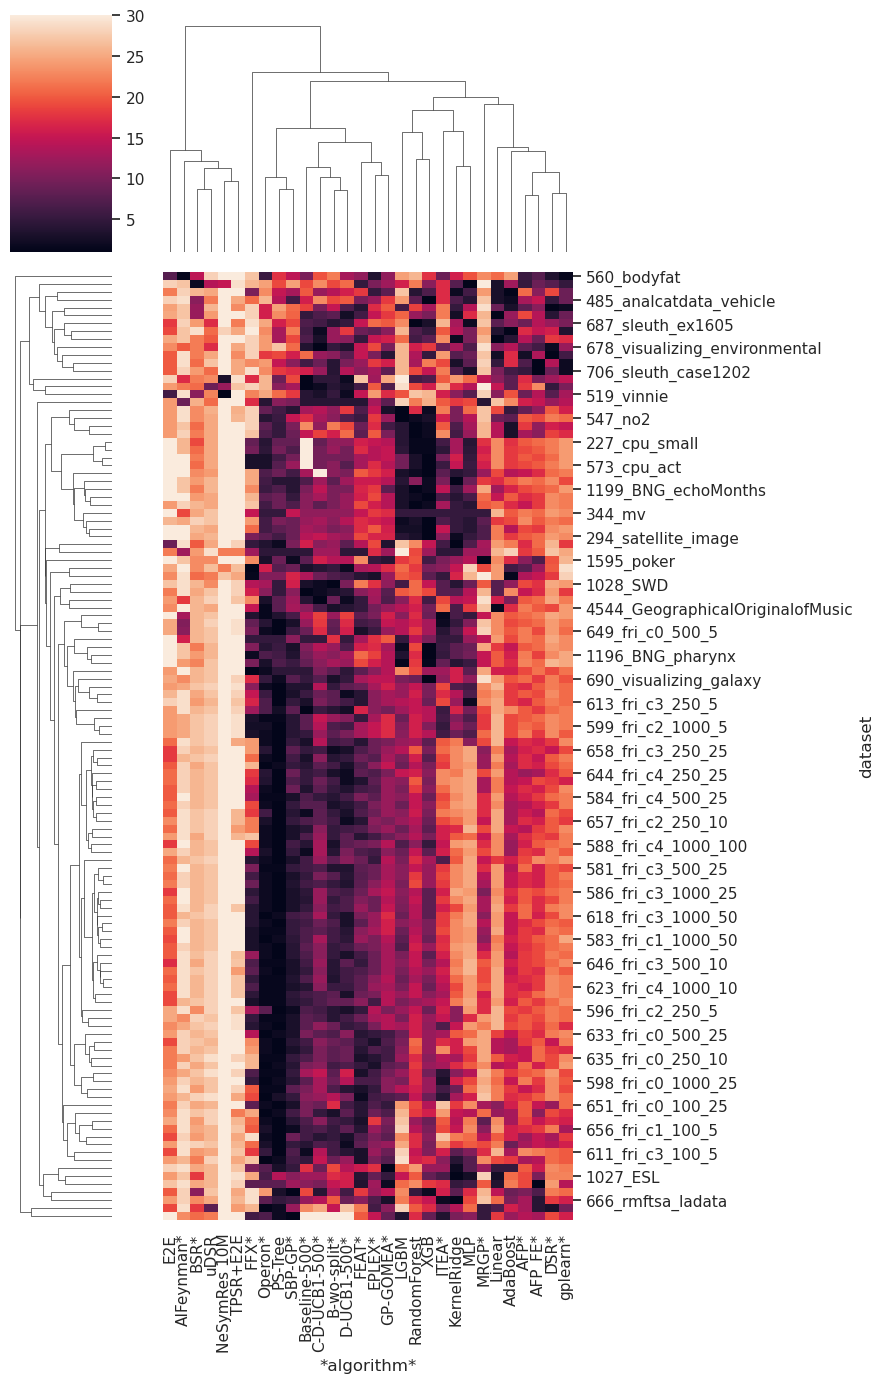

In [20]:
df_clustermap = data[["dataset", "*algorithm*", "r2_test_rank"]]\
        .groupby(["dataset", "*algorithm*"]).mean().reset_index().pivot("dataset", columns="*algorithm*").fillna(data["*algorithm*"].nunique())

df_clustermap.columns = df_clustermap.columns.droplevel()

g = sns.clustermap(
    df_clustermap,
    figsize=(9, 14)
)

plt.tight_layout()
save(name="clustermap")

In [21]:
df_clustermap = data[["dataset", "*algorithm*", "r2_test_rank"]]\
        .groupby(["dataset", "*algorithm*"]).mean().reset_index().pivot("dataset", columns="*algorithm*").fillna(data["*algorithm*"].nunique())

df_clustermap.columns = df_clustermap.columns.droplevel()
# df_sum
df_clustermap

/tmp/ipykernel_1376216/236141615.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_clustermap = data[["dataset", "*algorithm*", "r2_test_rank"]]\


*algorithm*,AFP*,AFP_FE*,AIFeynman*,AdaBoost,B-wo-split*,BSR*,Baseline-500*,C-D-UCB1-500*,D-UCB1-500*,DSR*,...,MRGP*,NeSymRes 10M,Operon*,PS-Tree,RandomForest,SBP-GP*,TPSR+E2E,XGB,gplearn*,uDSR
dataset,,,,,,,,,,,,,,,,,,,,,
1027_ESL,19.0,10.0,27.0,21.0,17.0,18.0,12.5,12.5,16.0,22.5,...,28.0,30.0,6.5,14.0,20.0,11.0,29.0,8.5,22.5,26.0
1028_SWD,19.0,17.5,29.0,11.5,1.0,26.0,3.0,2.0,10.0,25.0,...,20.0,30.0,13.0,5.0,21.0,16.0,28.0,15.0,24.0,23.0
1029_LEV,19.0,1.0,29.0,22.0,15.0,25.0,11.0,10.0,16.0,24.0,...,20.0,30.0,8.0,8.0,23.0,12.5,28.0,18.0,14.0,26.0
1030_ERA,20.0,15.5,29.0,5.0,19.0,25.0,17.5,9.0,14.0,23.0,...,12.0,30.0,7.5,3.0,24.0,5.0,27.0,12.0,22.0,26.0
1089_USCrime,21.0,11.0,28.0,1.0,14.0,26.0,20.0,12.0,16.0,19.0,...,24.0,30.0,23.0,15.0,4.0,13.0,30.0,7.0,9.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687_sleuth_ex1605,9.0,14.0,28.0,11.0,4.0,24.0,7.0,6.0,5.0,12.0,...,27.0,30.0,25.0,16.0,1.0,19.0,22.0,3.0,10.0,17.0
690_visualizing_galaxy,21.0,18.0,23.0,19.5,3.0,26.0,5.0,7.5,5.0,22.0,...,29.0,30.0,5.0,2.0,9.0,7.5,28.0,1.0,19.5,27.0
695_chatfield_4,19.0,14.0,27.0,12.0,8.0,12.0,5.0,7.0,2.5,4.0,...,26.0,30.0,16.0,23.0,12.0,20.5,30.0,10.0,9.0,24.0
